In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy
from shapely.geometry import point
import math

In [3]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning'

In [32]:
#loading in the current enrollment for only the 2024-25 school year
current_enrollment = pd.read_csv(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\marketshare_output_pu_2324_848_gr_2021_2425_long.csv')
#current_enrollment_2024 = current_enrollment[current_enrollment['year_str']=='2024-2025']

current_enrollment = current_enrollment.rename(columns = {'pu_2324_848':'pu_2324_84'})
current_enrollment = current_enrollment[['pu_2324_84','grade','fall_year','count','basez']].fillna(0)
current_enrollment

,pu_2324_84,grade,fall_year,count,basez
0,1.0,-2,2022,1.0,0.0
1,1.0,0,2021,1.0,1.0
2,1.0,0,2023,1.0,1.0
3,1.0,0,2024,1.0,1.0
4,1.0,1,2022,2.0,2.0
...,...,...,...,...,...
39033,843.0,1,2023,0.0,0.0
39034,843.0,4,2023,0.0,0.0
39035,844.0,1,2023,0.0,0.0
39036,844.0,2,2024,0.0,0.0


In [90]:
current_hs = current_enrollment[current_enrollment['grade'].isin([9,10,11,12])&current_enrollment['fall_year'].isin([2021,2022,2023])]
current_ms = current_enrollment[current_enrollment['grade'].isin([6,7,8])&current_enrollment['fall_year'].isin([2021,2022,2023])]
#average out counts over years 2021-2023
averaged_hs = current_hs.groupby(['pu_2324_84','grade'],as_index=False).mean()
averaged_ms = current_ms.groupby(['pu_2324_84','grade'],as_index=False).mean()

averaged_hs = averaged_hs.groupby(['pu_2324_84'],as_index=False).sum().drop(columns=['grade','fall_year'])
averaged_ms = averaged_ms.groupby(['pu_2324_84'],as_index=False).sum().drop(columns=['grade','fall_year'])

averaged_hs[['count', 'basez']] = averaged_hs[['count', 'basez']].map(lambda x: int(x))
averaged_ms[['count', 'basez']] = averaged_ms[['count', 'basez']].map(lambda x: int(x))

all_pus = pd.DataFrame({'pu_2324_84': range(1,852)})
hs_full = all_pus.merge(averaged_hs, on='pu_2324_84',how='left').fillna(0)
ms_full = all_pus.merge(averaged_ms, on='pu_2324_84',how='left').fillna(0)


In [3]:
#now we want to only show the 5th, 6th, 7th, and 8th grade - the grades that will be in high school in 2028-29
mask = current_enrollment['grade'].isin([9,10,11,12])
hs_2028 = current_enrollment[mask]
hs_2028 = hs_2028[['pu_2324_84','count','basez','lottery']]

In [4]:
#merging identical rows to get student counts by block and grade
columns_to_group = ['pu_2324_84']
hs_2028 = hs_2028.groupby(columns_to_group,as_index=False).sum() #as_index=False preserves the columns we are grouping by

#the planning units with zero enrollment are missing, so we must fill them with zeros
all_pus = pd.DataFrame({'pu_2324_84': range(1,852)})
hs_2028_full = all_pus.merge(hs_2028, on='pu_2324_84',how='left').fillna(0)
hs_2028_full

,pu_2324_84,count,basez,lottery
0,1,8.0,8.0,0.0
1,2,88.0,48.0,33.0
2,3,7.0,6.0,1.0
3,4,26.0,26.0,0.0
4,5,26.0,22.0,4.0
...,...,...,...,...
846,847,2.0,2.0,0.0
847,848,115.0,88.0,16.0
848,849,0.0,0.0,0.0
849,850,0.0,0.0,0.0


In [91]:
#read in the planning units
dps_pu = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\GIS_Files\\pu_2324_SPLIT.geojson').rename(columns={'pu_2324_848':'pu_2324_84'})
dps_pu = dps_pu.to_crs(epsg = 3857).sort_values(by='pu_2324_84')
dps_pu

,OBJECTID,pu_2324_84,X,Y,M_min,PS_ID,PUID2122_2,ps_id_833,psid_982,TIMS_PU,Region,Shape_Length,Shape_Area,geometry
0,1,1,2.049028e+06,893128.606346,0.0,589,589,1,1,PU589,North,26532.120021,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+..."
1,2,2,2.039923e+06,835434.121317,0.0,401,401,2,2,PU401,North,19333.085511,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."
2,3,3,2.058005e+06,797649.028742,0.0,782,782.0,3,3,PU782.0,East,18314.823119,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+..."
3,4,4,2.003222e+06,772895.737307,0.0,201,201.0,4,4,PU201.0,Southwest,29282.100083,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+..."
4,5,5,2.067334e+06,828244.230730,0.0,646,646,6,6,PU646,East,60685.151474,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,846,846,2.016360e+06,858711.587472,0.0,573,573,77,883,PU573,North,16660.241935,9.218197e+06,"POLYGON ((-8.79e+06 4.32e+06, -8.79e+06 4.32e+..."
849,847,847,2.013328e+06,854621.040074,0.0,322,322,50,50,PU322,North,9379.857191,3.748151e+06,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+..."
850,848,848,2.032661e+06,834741.061398,0.0,511,511,496,496,PU511,North,4334.417303,1.033344e+06,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+..."
201,849,849,2.040116e+06,820883.548010,0.0,292,292,255,255,PU292,North,35118.764031,2.898398e+07,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+..."


In [21]:
#read in the school locations
dps_base = gpd.read_file(r'C:\\Users\\olubl\\OneDrive\\College\\Data+\\DPS-Planning\\dps_base_2324.geojson')
dps_base = dps_base.to_crs(epsg = 3857)
base_hs = {'Jordan High School','Riverside High School','Northern High School','Hillside High School','Southern High School'}
dps_base_hs = dps_base[dps_base['name'].isin(base_hs)]
dps_base_hs

,OBJECTID,facilityid,sch_id6,sch_id,name,address,phone,agencyurl,operhours,spectype,...,region_base,region_physical,calendar_2324,calendar_2425,choice_2324,choice_2425,choice_2526,x_ncplane,y_ncplane,geometry
10,11,27253,320368,368,Southern High School,"800 Clayton Road Durham, NC 27703",919-560-3968,http://southern.dpsnc.net/pages/Southern_High,9:15am - 4:15pm,Magnet School,...,east,east,Traditional,Traditional,Energy & Sustainability,Energy & Sustainability,Energy & Sustainability,2050552.39,818903.23,POINT (-8.78e+06 4.3e+06)
14,15,87951,320325,325,Hillside High School,3727 Fayetteville Street Durham NC 27707,919-560-3925,http://hillside.dpsnc.net/pages/Hillside_High,9:15am - 4:15pm,None,...,southeast,southeast,Traditional,Traditional,International Baccalaureate,International Baccalaureate,International Baccalaureate,2028531.50,801909.91,POINT (-8.78e+06 4.29e+06)
55,56,6494,320356,356,Northern High School,4622 N Roxboro Road Durham NC 27712,919-560-3956,http://northern.dpsnc.net/pages/Northern_High,9:15am - 4:15pm,None,...,north,north,Traditional,Traditional,None,None,None,2029463.13,841220.63,POINT (-8.78e+06 4.31e+06)
56,57,12065,320365,365,Riverside High School,"3218 Rose of Sharon Road Durham, NC 27712",919-560-3965,http://www.edlinesites.net/pages/Riverside_High,9:15am - 4:15pm,None,...,central,north,Traditional,Traditional,None,None,None,2018531.26,843582.30,POINT (-8.79e+06 4.31e+06)
57,58,76194,320312,312,Jordan High School,6806 Garrett Road Durham NC 27707,919-560-3912,http://jordan.dpsnc.net/pages/Jordan_High,9:15am - 4:15pm,None,...,southwest,southwest,Traditional,Traditional,None,None,None,2011193.93,790759.00,POINT (-8.79e+06 4.29e+06)


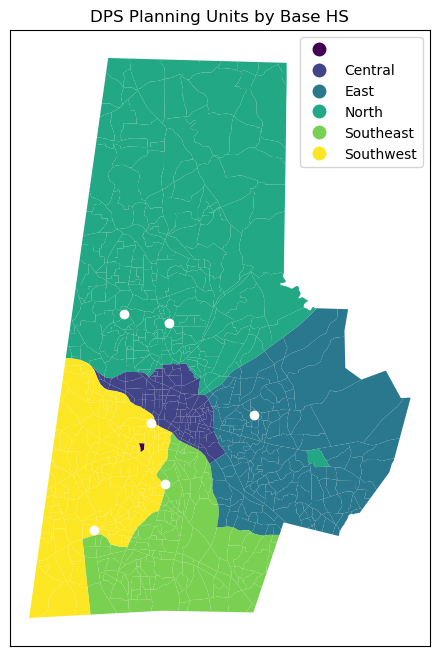

In [57]:
fig,ax = plt.subplots(figsize=(6,8))

dps_pu.plot(
    column = 'Region',
    legend = True,
    cmap = 'viridis',
    ax = ax
)
dps_base_hs.plot(ax=plt.gca(),zorder = 1, color = 'white')


ax.set_xticks([])
ax.set_yticks([])


plt.title('DPS Planning Units by Base HS')
plt.show()

In [51]:
hs_2028_geo = dps_pu.merge(hs_2028_full, on = 'pu_2324_84')[['pu_2324_84','X','Y','Region','Shape_Area','geometry','count','basez','lottery']]
#merge the student counts with the geometries
hs_2028_geo['centroid'] = hs_2028_geo['geometry'].centroid
hs_2028_geo
#now we have the student counts and geometries for each planning unit

,pu_2324_84,X,Y,Region,Shape_Area,geometry,count,basez,lottery,centroid
0,1,2.049028e+06,893128.606346,North,3.556198e+07,"POLYGON ((-8.77e+06 4.33e+06, -8.77e+06 4.33e+...",1.0,0.0,1.0,POINT (-8.78e+06 4.33e+06)
1,2,2.039923e+06,835434.121317,North,2.080136e+07,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",9.0,4.0,4.0,POINT (-8.78e+06 4.31e+06)
2,3,2.058005e+06,797649.028742,East,1.329077e+07,"POLYGON ((-8.77e+06 4.29e+06, -8.77e+06 4.29e+...",2.0,2.0,0.0,POINT (-8.77e+06 4.29e+06)
3,4,2.003222e+06,772895.737307,Southwest,4.684140e+07,"POLYGON ((-8.79e+06 4.29e+06, -8.79e+06 4.29e+...",2.0,1.0,1.0,POINT (-8.79e+06 4.28e+06)
4,5,2.067334e+06,828244.230730,East,1.497046e+08,"POLYGON ((-8.77e+06 4.3e+06, -8.77e+06 4.3e+06...",8.0,6.0,1.0,POINT (-8.77e+06 4.3e+06)
...,...,...,...,...,...,...,...,...,...,...
846,846,2.016360e+06,858711.587472,North,9.218197e+06,"POLYGON ((-8.79e+06 4.32e+06, -8.79e+06 4.32e+...",0.0,0.0,0.0,POINT (-8.79e+06 4.32e+06)
847,847,2.013328e+06,854621.040074,North,3.748151e+06,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+...",1.0,1.0,0.0,POINT (-8.79e+06 4.31e+06)
848,848,2.032661e+06,834741.061398,North,1.033344e+06,"POLYGON ((-8.78e+06 4.31e+06, -8.78e+06 4.31e+...",8.0,7.0,1.0,POINT (-8.78e+06 4.31e+06)
849,849,2.040116e+06,820883.548010,North,2.898398e+07,"POLYGON ((-8.79e+06 4.31e+06, -8.79e+06 4.31e+...",0.0,0.0,0.0,POINT (-8.79e+06 4.31e+06)


<Axes: >

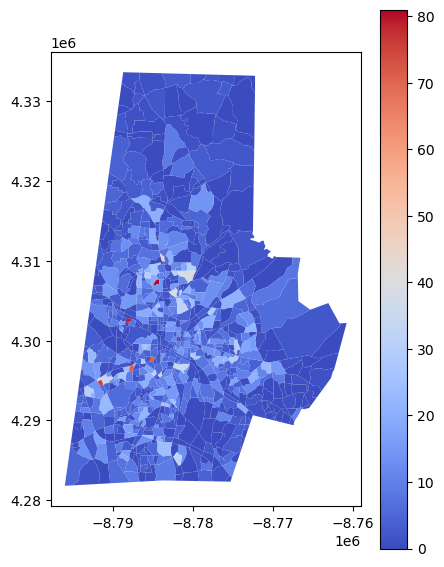

In [31]:
fig,ax = plt.subplots(figsize = (5,7))

hs_2028_geo.plot(
    column = 'basez',
    cmap = 'coolwarm',
    ax = ax,
    legend = True
)

In [11]:
#goal counts:
#Southern: 1700, Hillside: 1700, Northern: 1700, Riverside: 1700, Jordan: 2000

In [34]:
dps_base_hs = dps_base_hs[['name','geometry']]
dps_base_hs.loc[5,'name']='New High School'
dps_base_hs = dps_base_hs.reset_index()

In [59]:
def score_candidate(candidate):
    school_names = ['Southern High School','Hillside High School','Northern High School','Riverside High School','Jordan High School','New High School']
    capacities = [1600,1810,1540,1540,1535,1600]

    counts = pd.DataFrame({'school':school_names,
                           'capacity':capacities,
                           'count':[0,0,0,0,0,0],
                           'coefficient':[1,1,1,1,1,1]
                            })                               #initialize counts dataframe

    
    candidate_geom = candidate['geometry']
    dps_base_hs.loc[5,'geometry']=candidate_geom.centroid
    

    for i in range(20):                                      #iterative boundary assignment (running 10x)
        assignments = []
        for pu in hs_2028_geo.itertuples(index=False):                   
            centroid = pu.geometry.centroid
            pu_scores = []
            for j in range(6):                               #5 existing schools and 1 new
                dist = centroid.distance(dps_base_hs.loc[j,'geometry'])
                score = dist * counts.loc[j,'coefficient']
                pu_scores.append(score)
            assign = school_names[pu_scores.index(min(pu_scores))]
            assignments.append(assign)                        #collect hs assignments based on min distance score
        hs_2028_geo['assign'] = assignments

        for i,school in enumerate(school_names):
            assigned_students = hs_2028_geo.loc[hs_2028_geo['assign'] == school, 'count'].sum()
            counts.loc[i, 'count'] = assigned_students                    #sum up counts for all high schools and update coefficients
        counts['coefficient'] *= (counts['count']/counts['capacity'])**0.3

    objective=hs_2028_geo.merge(dps_base_hs,left_on='assign',right_on='name',how='left')
    objective['distance']=objective['geometry_x'].distance(objective['geometry_y'])
    objective_score = (objective['count']*objective['distance']).sum()

    return objective_score,counts

    

In [58]:
candidate = dps_pu.loc[515]

In [60]:
score_candidate(candidate)

(34782851.05915354,
                   school  capacity  count  coefficient
 0   Southern High School      1600   1470     0.712485
 1   Hillside High School      1810   1669     0.666312
 2   Northern High School      1540   1380     0.668051
 3  Riverside High School      1540   1464     0.542588
 4     Jordan High School      1535   1399     0.559447
 5        New High School      1600   1498     0.524018)

<Axes: >

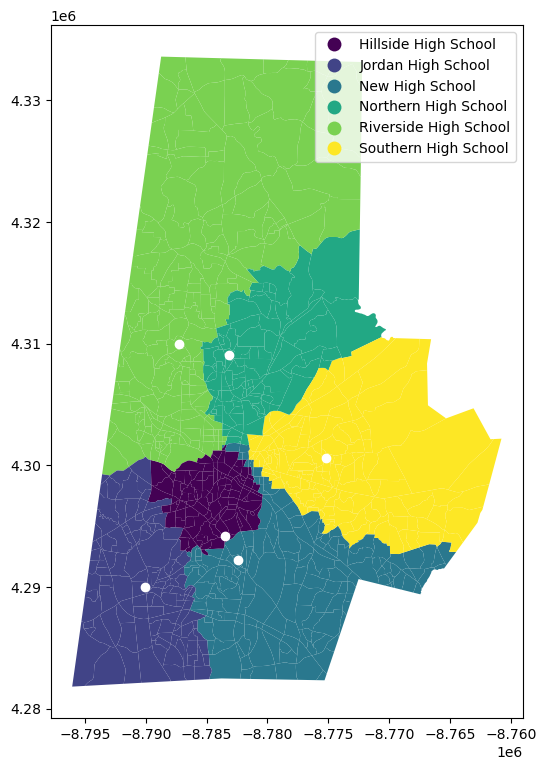

In [61]:
fig,ax = plt.subplots(figsize = (7,9))

hs_2028_geo.plot(
    column='assign',
    ax = ax,
    cmap = 'viridis',
    legend = True
)
dps_base_hs.plot(ax=plt.gca(), color = 'white')

In [95]:
hs_full_geo = dps_pu.merge(hs_full,on='pu_2324_84',how='left')[['pu_2324_84','X','Y','Region','Shape_Area','geometry','count','basez']]
ms_full_geo = dps_pu.merge(ms_full,on='pu_2324_84',how='left')[['pu_2324_84','X','Y','Region','Shape_Area','geometry','count','basez']]

In [97]:
hs_full_geo.to_file('hs_full_geo.geojson')
ms_full_geo.to_file('ms_full_geo.geojson')